In [1]:
from paretoGraphTeams import *
import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Import datasets
# IMDB
imdb_experts_1, imdb_tasks_1, imdb_costs_1, _ = import_pickled_datasets('imdb', 1)
imdb_experts_2, imdb_tasks_2, imdb_costs_2, _ = import_pickled_datasets('imdb', 2)
# imdb_experts_3, imdb_tasks_3, imdb_costs_3, _ = import_pickled_datasets('imdb', 3)

# Bibsonomy
bbsm_experts_1, bbsm_tasks_1, bbsm_costs_1, _ = import_pickled_datasets('bbsm', 1)
# bbsm_experts_2, bbsm_tasks_2, bbsm_costs_2, _ = import_pickled_datasets('bbsm', 2)

# Freelancer
fl_experts_1, fl_tasks_1, fl_costs_1, _ = import_pickled_datasets('freelancer', 1)
# fl_experts_2, fl_tasks_2, fl_costs_2, _ = import_pickled_datasets('freelancer', 2)

2026-02-07 19:06:35,736 |INFO: Imported imdb experts, Num Experts: 200
2026-02-07 19:06:35,737 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-07 19:06:35,738 |INFO: Imported imdb costs, Num Costs: 200
2026-02-07 19:06:35,742 |INFO: Imported imdb graph matrix, Shape: (1000, 1000)

2026-02-07 19:06:35,743 |INFO: Imported imdb experts, Num Experts: 400
2026-02-07 19:06:35,744 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-07 19:06:35,745 |INFO: Imported imdb costs, Num Costs: 400
2026-02-07 19:06:35,751 |INFO: Imported imdb graph matrix, Shape: (3000, 3000)

2026-02-07 19:06:35,753 |INFO: Imported bbsm experts, Num Experts: 250
2026-02-07 19:06:35,754 |INFO: Imported bbsm tasks, Num Tasks: 300
2026-02-07 19:06:35,755 |INFO: Imported bbsm costs, Num Costs: 250
2026-02-07 19:06:35,756 |INFO: Imported bbsm graph matrix, Shape: (500, 500)

2026-02-07 19:06:35,757 |INFO: Imported freelancer experts, Num Experts: 50
2026-02-07 19:06:35,758 |INFO: Imported freelancer tasks, Num Tasks: 25

In [2]:
def expertCoordinationAdjacencyMatrix(expert_list, use_jaccard=False):
    '''
    Create a coordination graph adjacency matrix of dimension len(expert_list)*len(expert_list) from a list of experts.
    If use_jaccard is True, the distance between two experts is the Jaccard distance.
    Otherwise, the distance between two experts is defined as 10*e^(-0.1*D) where D is the number of skills they have in common.
    '''
    n = len(expert_list)
    graphmat = np.zeros((n, n))
    for i in range(n):
        skills_i = set(expert_list[i])
        for j in range(n):
            if i != j:
                skills_j = set(expert_list[j])
                if use_jaccard:
                    union = skills_i | skills_j
                    if len(union) == 0:
                        graphmat[i, j] = 0.0
                    else:
                        inter = skills_i & skills_j
                        graphmat[i, j] = 1.0 - (len(inter) / len(union))
                else:
                    common_skills = len(skills_i & skills_j)
                    graphmat[i, j] = np.exp(-0.1 * common_skills)
    
    return graphmat

### Average Plotting across Tasks

In [ ]:
def findApproximateParetoSolutions(tasks_list, experts_list, graphmat,
                                   sizeUniverse, numExperts, numTasks, maxDiameter,
                                   dataset_name=None, start_index=0):
    '''
    Run graph-diameter algorithm over multiple tasks, aggregate results, and plot mean +/- std.
    '''
    # Diameter grid (same for all tasks)
    num_steps, min_diameter = 15, 0.0
    diameter_arr = np.linspace(min_diameter, maxDiameter, num_steps)

    algo_names = ["C-Greedy-Diameter", "PruneGraph", "DistanceGreedy", "TopDegree"]

    def align_to_diameter_arr(diameters, covs):
        if len(diameters) == 0 or len(covs) == 0:
            return np.zeros_like(diameter_arr, dtype=float)
        diameters = np.array(diameters, dtype=float)
        covs = np.array(covs, dtype=float)

        # Ensure matching lengths
        min_len = min(len(diameters), len(covs))
        diameters = diameters[:min_len]
        covs = covs[:min_len]

        # Aggregate duplicate diameters by taking max coverage
        agg = {}
        for d, c in zip(diameters, covs):
            if d in agg:
                agg[d] = max(agg[d], c)
            else:
                agg[d] = c
        if len(agg) == 0:
            return np.zeros_like(diameter_arr, dtype=float)
        diameters_sorted = np.array(sorted(agg.keys()), dtype=float)
        covs_sorted = np.array([agg[d] for d in diameters_sorted], dtype=float)

        return np.interp(diameter_arr, diameters_sorted, covs_sorted, left=covs_sorted[0], right=covs_sorted[-1])

    # containers across tasks
    all_coverages = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    # frontier size counts per task
    cgreedy_size_counts = []
    prune_size_counts = []
    distance_size_counts = []
    topk_size_counts = []

    # iterate tasks
    for task_index in range(start_index, start_index + numTasks):
        # per-task containers
        task_coverages = {alg: [] for alg in algo_names}
        task_runtimes = {alg: [] for alg in algo_names}

        # Initialize Pareto teams object
        pareto_diam = paretoGraph(task=tasks_list[task_index],
                                  n_experts=experts_list[:numExperts],
                                  pairwise_costs=graphmat[:numExperts, :numExperts],
                                  size_univ=sizeUniverse,
                                  budget=1)

        diameters, best_coverages, _, _, runTime = pareto_diam.ParetoGreedyDiameter()
        diameters = np.array(diameters, dtype=float)
        best_coverages = np.array(best_coverages, dtype=float)

        # Interpolate to shared diameter grid
        task_coverages['C-Greedy-Diameter'] = list(align_to_diameter_arr(diameters, best_coverages))
        task_runtimes['C-Greedy-Diameter'].append(runTime)
        cgreedy_size_counts.append(len(diameters))

        # Plain Greedy (distance-scaled) baseline
        pg_diam, pg_covs, _, _, pg_time = pareto_diam.plainGreedyDistanceScaled()
        task_coverages['DistanceGreedy'] = list(align_to_diameter_arr(pg_diam, pg_covs))
        task_runtimes['DistanceGreedy'].append(pg_time)
        distance_size_counts.append(len(pg_diam))

        # Top-K (distance-scaled) baseline
        tk_diam, tk_covs, _, _, tk_time = pareto_diam.topKDegree()
        task_coverages['TopDegree'] = list(align_to_diameter_arr(tk_diam, tk_covs))
        task_runtimes['TopDegree'].append(tk_time)
        topk_size_counts.append(len(tk_diam))

        # Graph pruning baseline (already returns diameters)
        pr_radii, pr_coverages, _, _, pr_time = pareto_diam.graphPruning()
        pr_diameters = np.array(pr_radii, dtype=float)
        pr_coverages = np.array(pr_coverages, dtype=float)
        task_coverages['PruneGraph'] = list(align_to_diameter_arr(pr_diameters, pr_coverages))
        task_runtimes['PruneGraph'].append(pr_time)
        prune_size_counts.append(len(pr_diameters))

        # convert per-task lists to numpy arrays and store in all_coverages
        for alg in algo_names:
            arr = np.array(task_coverages[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(diameter_arr, dtype=float)
            all_coverages[alg].append(arr)
            runtimes = task_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    # compute mean and std across tasks for each algorithm
    mean_coverages = {}
    std_coverages = {}
    for alg in algo_names:
        stacked = np.vstack(all_coverages[alg])  # shape (numTasks, len(diameter_arr))
        mean_coverages[alg] = np.mean(stacked, axis=0)
        std_coverages[alg] = np.std(stacked, axis=0)

    mean_cgreedy_size = float(np.mean(cgreedy_size_counts)) if len(cgreedy_size_counts) > 0 else 0.0
    mean_prune_size = float(np.mean(prune_size_counts)) if len(prune_size_counts) > 0 else 0.0
    mean_distance_size = float(np.mean(distance_size_counts)) if len(distance_size_counts) > 0 else 0.0
    mean_topk_size = float(np.mean(topk_size_counts)) if len(topk_size_counts) > 0 else 0.0

    mean_frontier_sizes = {
        "C-Greedy-Diameter": mean_cgreedy_size,
        "PruneGraph": mean_prune_size,
        "DistanceGreedy": mean_distance_size,
        "TopDegree": mean_topk_size,
    }

    # Plot mean coverage with shaded std band
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "C-Greedy-Diameter": tab10_colors[2],
        "PruneGraph": tab10_colors[3],
        "DistanceGreedy": tab10_colors[1],
        "TopDegree": tab10_colors[0],
    }
    marker_map = {
        "C-Greedy-Diameter": "X",
        "PruneGraph": "o",
        "DistanceGreedy": "s",
        "TopDegree": "^",
    }
    linestyle_map = {
        "C-Greedy-Diameter": (0, (3, 2)),
        "PruneGraph": (0, (4, 2)),
        "DistanceGreedy": (0, (2, 2)),
        "TopDegree": (0, (1, 1)),
    }

    fig, ax = plt.subplots(figsize=(9, 5.5))
    label_map = {}
    rng = np.random.default_rng()

    def pick_marker_indices(count):
        if diameter_arr.size == 0 or count <= 0:
            return np.array([], dtype=int)
        count = int(max(2, min(diameter_arr.size, count)))
        if count == 1:
            return np.array([0], dtype=int)
        step = (diameter_arr.size - 1) / float(count - 1)
        max_offset = max(0.0, step - 1.0)
        offset = rng.uniform(0.0, max_offset) if max_offset > 0 else 0.0
        idx = np.round(offset + step * np.arange(count)).astype(int)
        idx = np.clip(idx, 0, diameter_arr.size - 1)
        idx = np.unique(idx)
        if idx.size < 2:
            idx = np.unique(np.round(np.linspace(0, diameter_arr.size - 1, count)).astype(int))
        return idx

    for i, alg in enumerate(algo_names):
        mean = mean_coverages[alg]
        std = std_coverages[alg] * 0.5
        is_pareto = alg == "C-Greedy-Diameter"
        marker_size = 8 if is_pareto else 7
        line_style = linestyle_map.get(alg, (0, (1, 1)))

        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, 'o')
        zorder = 4 if is_pareto else 3

        label = rf"\texttt{{{alg}}}"
        label_map[alg] = label
        ax.plot(diameter_arr, mean,
                label=label,
                color=color,
                linestyle=line_style,
                linewidth=1.8,
                zorder=zorder)
        marker_count = int(np.round(mean_frontier_sizes.get(alg, 0.0)))
        marker_idx = pick_marker_indices(marker_count)
        if marker_idx.size > 0:
            ax.scatter(diameter_arr[marker_idx], mean[marker_idx],
                       label="_nolegend_",
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
        ax.fill_between(diameter_arr,
                        np.clip(mean - std, 0, 1),
                        np.clip(mean + std, 0, 1),
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Team diameter, $c_d$', fontsize=28)
    ax.set_ylabel(r'Task coverage, $f$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    # Legend handles (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        from matplotlib.lines import Line2D
        ordered_labels = [
            label_map["C-Greedy-Diameter"],
            label_map["PruneGraph"],
            label_map["DistanceGreedy"],
            label_map["TopDegree"],
        ]
        ordered_handles = []
        for alg in ["C-Greedy-Diameter", "PruneGraph", "DistanceGreedy", "TopDegree"]:
            is_pareto = alg == "C-Greedy-Diameter"
            marker_size = 8 if is_pareto else 7
            ordered_handles.append(
                Line2D([0], [0],
                       color=color_map.get(alg, "k"),
                       linestyle=linestyle_map.get(alg, (0, (1, 1))),
                       marker=marker_map.get(alg, 'o'),
                       markersize=marker_size,
                       markeredgewidth=1.1,
                       markeredgecolor='k',
                       linewidth=1.8)
            )

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "graph"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_graph.pdf"
    # fig.savefig(out_path, bbox_inches="tight")

    # Save legend as separate PDF
    if handles:
        legend_out_path = plots_dir / "graph_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(ordered_handles, ordered_labels, loc='center', ncol=2, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)

    plt.show()

    # Runtime summary (latex row)
    dataset_label = dataset_name or "dataset"
    dataset_macro_map = {
        "Freelancer": r"\freelancer",
        "Bbsm": r"\bibsonomy",
        "IMDB-1": r"\imdbone",
        "IMDB-2": r"\imdbtwo",
    }
    dataset_macro = dataset_macro_map.get(dataset_label, rf"\\dataset{{{dataset_label}}}")
    mean_cgreedy_rt = float(np.mean(all_runtimes['C-Greedy-Diameter'])) if len(all_runtimes['C-Greedy-Diameter']) > 0 else 0.0
    mean_prune_rt = float(np.mean(all_runtimes['PruneGraph'])) if len(all_runtimes['PruneGraph']) > 0 else 0.0
    mean_distance_rt = float(np.mean(all_runtimes['DistanceGreedy'])) if len(all_runtimes['DistanceGreedy']) > 0 else 0.0
    mean_topk_rt = float(np.mean(all_runtimes['TopDegree'])) if len(all_runtimes['TopDegree']) > 0 else 0.0
    runtime_row = (
        f"{dataset_macro} "
        f"& {mean_cgreedy_rt:.3f} "
        f"& {mean_prune_rt:.3f} "
        f"& {mean_distance_rt:.3f} "
        f"& {mean_topk_rt:.3f} \\\\"
    )
    logging.info(runtime_row)

    # Mean frontier sizes summary (latex row)
    frontier_row = (
        f"{dataset_macro} "
        f"& {mean_cgreedy_size:.3f} "
        f"& {mean_prune_size:.3f} "
        f"& {mean_distance_size:.3f} "
        f"& {mean_topk_size:.3f} \\\\"
    )
    logging.info(frontier_row)

    summary_dir = plots_dir / "summary"
    summary_dir.mkdir(parents=True, exist_ok=True)
    runtimes_path = summary_dir / "runtimes.txt"
    frontier_path = summary_dir / "frontier-size.txt"
    with open(runtimes_path, "a", encoding="utf-8") as runtime_file:
        runtime_file.write(runtime_row + "\n")
    with open(frontier_path, "a", encoding="utf-8") as frontier_file:
        frontier_file.write(frontier_row + "\n")

## Freelancer-1

2026-02-07 19:06:35,818 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[26, 42, 22, 44], Num Experts:50, Budget=1
2026-02-07 19:06:35,821 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.002s
2026-02-07 19:06:35,824 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.002s
2026-02-07 19:06:35,828 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.003s
2026-02-07 19:06:35,870 |INFO: GraphPruning finished: max_coverage=1.000, runtime=0.041s
2026-02-07 19:06:35,871 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[35, 45, 28, 13], Num Experts:50, Budget=1
2026-02-07 19:06:35,874 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.003s
2026-02-07 19:06:35,878 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.003s
2026-02-07 19:06:35,888 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.004s
2026-02-07 19:06:35,905 |INFO: GraphPruning finished: max

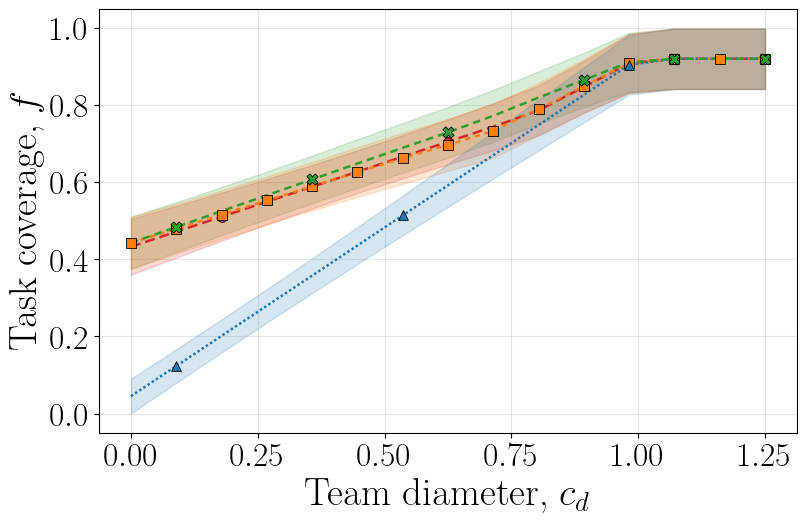

2026-02-07 19:06:37,482 |INFO: \freelancer & 0.003 & 0.019 & 0.008 & 0.003 \\
2026-02-07 19:06:37,486 |INFO: \freelancer & 2.800 & 2.500 & 15.050 & 2.000 \\


In [4]:
fl_graphmat_1 = expertCoordinationAdjacencyMatrix(fl_experts_1[:50], use_jaccard=True)
findApproximateParetoSolutions(tasks_list=fl_tasks_1, experts_list=fl_experts_1, graphmat=fl_graphmat_1,
                               sizeUniverse=50, numExperts=50, numTasks=20,
                               maxDiameter=1.25 * np.max(fl_graphmat_1),
                               dataset_name="Freelancer")

## IMDB

2026-02-07 19:06:37,561 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[0, 1, 2, 3, 4, 5, 6, 7], Num Experts:150, Budget=1
2026-02-07 19:06:37,572 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.010s
2026-02-07 19:06:37,581 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.008s
2026-02-07 19:06:37,598 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.016s
2026-02-07 19:06:37,790 |INFO: GraphPruning finished: max_coverage=1.000, runtime=0.191s
2026-02-07 19:06:37,791 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[1, 3, 4, 6, 8], Num Experts:150, Budget=1
2026-02-07 19:06:37,798 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.007s
2026-02-07 19:06:37,803 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.003s
2026-02-07 19:06:37,817 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.013s
2026-02-07 19:06:38,007 |INFO: GraphPruning fini

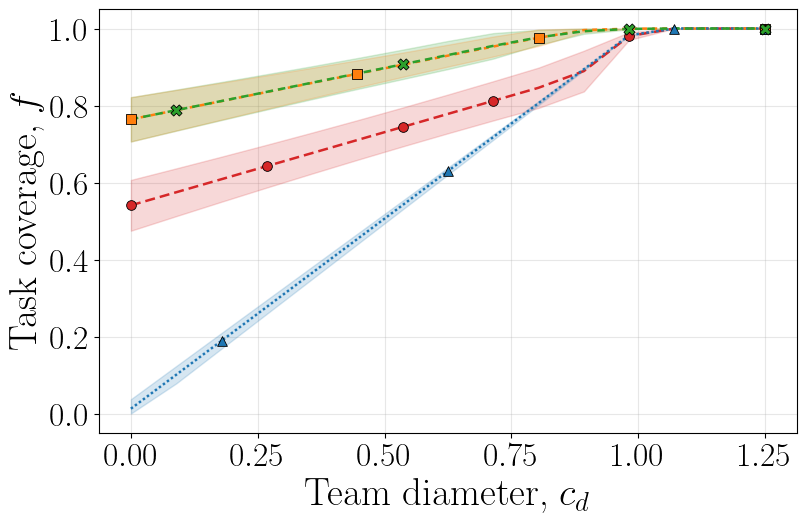

2026-02-07 19:06:44,174 |INFO: \imdbone & 0.007 & 0.189 & 0.003 & 0.014 \\
2026-02-07 19:06:44,174 |INFO: \imdbone & 2.067 & 2.533 & 1.967 & 2.000 \\


In [5]:
imdb_graphmat_1 = expertCoordinationAdjacencyMatrix(imdb_experts_1[:150])
findApproximateParetoSolutions(tasks_list=imdb_tasks_1, experts_list=imdb_experts_1, graphmat=imdb_graphmat_1,
                               sizeUniverse=24, numExperts=150, numTasks=30,
                               maxDiameter=1.25 * np.max(imdb_graphmat_1),
                               dataset_name="IMDB-1")

2026-02-07 19:06:44,410 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[0, 1, 2, 3, 4, 5, 6, 7, 8], Num Experts:300, Budget=1
2026-02-07 19:06:44,424 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.014s
2026-02-07 19:06:44,437 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.012s
2026-02-07 19:06:44,500 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.063s
2026-02-07 19:06:45,518 |INFO: GraphPruning finished: max_coverage=1.000, runtime=1.017s
2026-02-07 19:06:45,519 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[0, 5, 9, 10, 11], Num Experts:300, Budget=1
2026-02-07 19:06:45,534 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.015s
2026-02-07 19:06:45,558 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.018s
2026-02-07 19:06:45,636 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.075s
2026-02-07 19:06:46,706 |INFO: GraphPruning

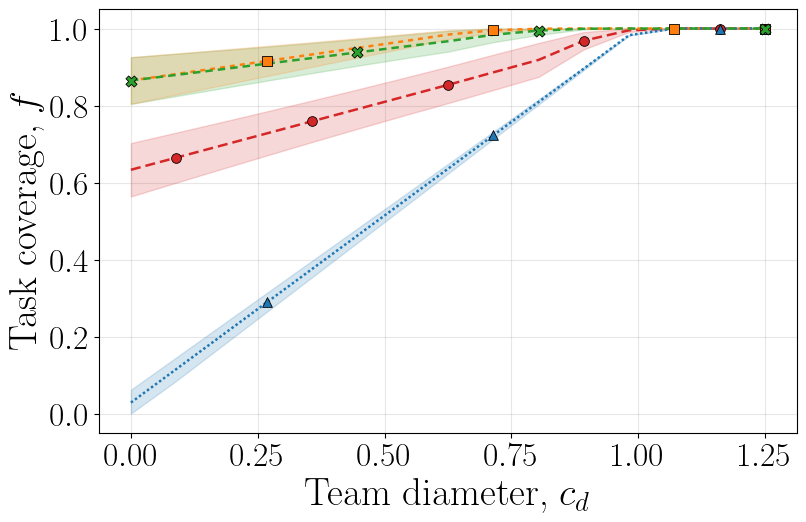

2026-02-07 19:07:18,204 |INFO: \imdbtwo & 0.014 & 1.031 & 0.006 & 0.066 \\
2026-02-07 19:07:18,205 |INFO: \imdbtwo & 1.733 & 2.967 & 1.667 & 2.000 \\


In [6]:
imdb_graphmat_2 = expertCoordinationAdjacencyMatrix(imdb_experts_2[:300])
findApproximateParetoSolutions(tasks_list=imdb_tasks_2, experts_list=imdb_experts_2, graphmat=imdb_graphmat_2,
                               sizeUniverse=24, numExperts=300, numTasks=30,
                               maxDiameter=1.25 * np.max(imdb_graphmat_2),
                               dataset_name="IMDB-2")

## Bbsm-1

2026-02-07 19:07:18,438 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[67, 51, 4, 52], Num Experts:250, Budget=1
2026-02-07 19:07:18,454 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.015s
2026-02-07 19:07:18,455 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.001s
2026-02-07 19:07:18,550 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.093s
2026-02-07 19:07:19,222 |INFO: GraphPruning finished: max_coverage=1.000, runtime=0.670s
2026-02-07 19:07:19,223 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[65, 1, 70, 51, 22, 56], Num Experts:250, Budget=1
2026-02-07 19:07:19,230 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.007s
2026-02-07 19:07:19,237 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.005s
2026-02-07 19:07:19,277 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.039s
2026-02-07 19:07:19,986 |INFO: GraphPruning finis

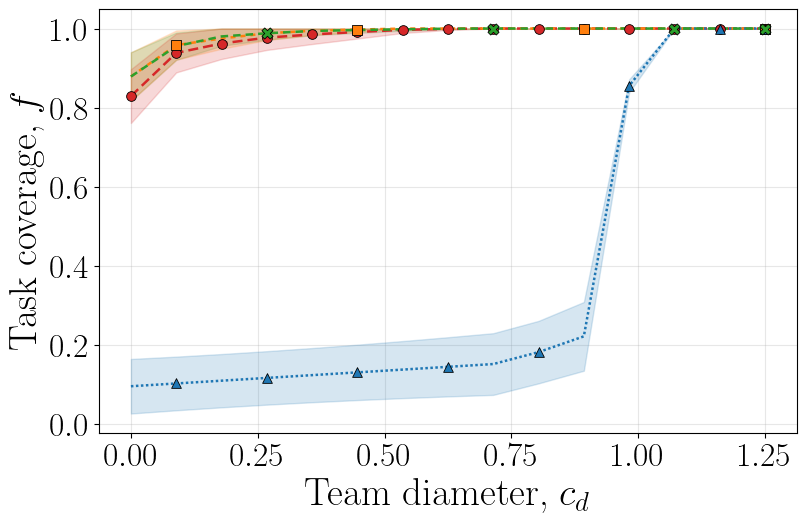

2026-02-07 19:07:40,051 |INFO: \bibsonomy & 0.008 & 0.659 & 0.003 & 0.042 \\
2026-02-07 19:07:40,052 |INFO: \bibsonomy & 1.600 & 9.633 & 1.567 & 4.000 \\


In [7]:
bbsm_graphmat_1 = expertCoordinationAdjacencyMatrix(bbsm_experts_1[:250])
findApproximateParetoSolutions(tasks_list=bbsm_tasks_1, experts_list=bbsm_experts_1, graphmat=bbsm_graphmat_1,
                               sizeUniverse=75, numExperts=250, numTasks=30,
                               maxDiameter=1.25 * np.max(bbsm_graphmat_1),
                               dataset_name="Bbsm")